# Shibsted data science home assignment
Hello! This is my submission to the assignment. It begins with my interpretation of the task, followed by a solution.

Task: Given a dataset of ~1000 images, find an underlying pattern in the dataset.
After looking at some of the images, I figure that the task is to classify them into different categories and then infer some kind of compostion of the dataset.

Disposition:
* Classify the images
* Visualize the result
* Find a pattern

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image

# Model for prediction
Since I do not have any labeled images and limited time and compute resources I use a pretrained CNN model. I use ResNet-50 out of the box, trained on the ImageNet-1K dataset, with default weights. However, this model classifies the images as one of the 1000 ImageNet categories. A quick visual probe of ~30 images reveal that they seem to all be of one out the four categories: "sea creature", referred to as "fish", "canine", refered to as "dog", "large machine", referred to as "car" and "human propelled small vehichle", referred to as "bike". Since these categories have a more coarse granularity and differ from the ImageNet-1K ones, we need to map from their category to ours. We do this through a mapping function below.

In [301]:
def predict(img, model, weights):
    """Uses model and weights to predict the category of image img.
    
    Parameters
    ----------
    img :  Torch.tensor 
        A tensor of dimension [3, height, width] representing the image
    
    Returns
    -------
    prediction : Torch.tensor
        The scores for each category 
    """
    preprocess = weights.transforms()
    batch = preprocess(img).unsqueeze(0)
    prediction = model(batch).squeeze(0).softmax(0)  
    return prediction

In [324]:
def map_prediction(prediction):
    """Maps ImageNet categories to our categories.

    ImageNet has a much higher granularity than we do, so we map need to
    map their predictions to our four categories: 'car','bike','fish','dog'.
    This is accomplished by for each of the four categories, cumulating 
    the scores for the ImageNet-categories that could be interpreted as 
    subcategories to it, and infering the one with highest sum. Since the
    number of ImageNet-categories that map our categories are very 
    unbalanced, we normalize with this number, getting an average score per
    category.
    
    Parameters
    ----------
    prediction :  torch.Tensor
        Containing the score for each of the 1000 ImageNet-1k categories
    
    Returns
    -------
    best_score : float
        The highest score for one of our four categories
    
    category_name : str
        The category of our four that recieved highest score
    """
    
    # selecting indices from the imageNet-1k class list 
    # that correspond to our superclasses 
    dog_index = list(range(151, 281))
    bike_index = [444, 670, 671, 870, 880]
    car_index = [407, 436, 468, 475, 511, 573, 575, 581, 627, 654, 656, 659, 751, 817, 864]
    fish_index = list(range(0,7)) + list(range(107,127)) + list(range(147,151)) + list(range(327,330)) + list(range(389,398))
    
    categories = ["dog", "bike", "car", "fish"]
    indices = [dog_index, bike_index, car_index, fish_index]
    sums = []
    
    # getting the score aggregated from the ImageNet-subcategories. 
    # This is not actually an adequate score since it is the average 
    # of the score from the categories of interest. Some  of the ImageNet
    # categories may have a very high score but is smoothened out by other
    # not as similar objects in the same clustering. However, it works 
    # well as a decision metric between our four categories.
    for i in indices:
        sums.append(sum(prediction[i]).item() / len(i))
    
    # finding best scoring category
    best_score = 0
    for sum_, category in zip(sums, categories):
        if (sum_ > best_score):
            category_name = category
            best_score = sum_
            
    return best_score, category_name        

In [308]:
def imageNet_prediction(prediction, weights): 
    """Retrieving the best prediction out of ImageNet-1k categories
    
    Parameters
    ----------
    prediction :  torch.Tensor
        Containing the score for each of the 1000 ImageNet-1k categories
    
    Returns
    -------
    best_score : float
        The highest scoring ImageNet-1k category 
    
    category_name : str
        The category of ImageNet-1k that recieved highest score
    """
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    return score, category_name

In [303]:
def show_image(prefix):
    """Showing the image with filename prefix.jpg
    
    Parameters
    ----------
    number :  str or int
        The prefix the file name that is to be shown.

    Returns
    -------
    img : torch.Tensor
        The tensor representation of the image
    """
   
    path = "Dataset/" + str(prefix) + ".jpg" 
    img = read_image(path)
    
    # in case it is a black and white image there is only one color dimension
    # so we just repeat the matrix thre times in order to fit the desired format.
    if (img.size()[0] < 3):
        img = np.repeat(img, 3, 0)
    
    # plt.imshow uses another format so we need to move the dimensions around.
    plt.imshow(img.permute(1, 2, 0));
    return img

In [ ]:
# Using a pretrained image classifier from PyTorch
# trained on ImageNet-1k, 1000 categories.
# Standard weights.
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).eval()

Image net prediction: goldfish
Our mapped prediction: fish


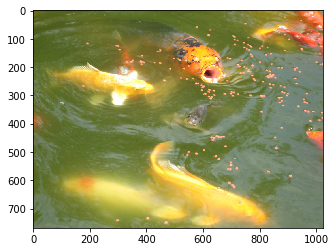

In [349]:
## testing functions:
image_number = 173
img = show_image(image_number)
prediction = predict(img, model, weights)
in_score, in_label = imageNet_prediction(prediction, weights)
our_score, our_label = map_prediction(prediction)
print(f"Image net prediction: {in_label}\nOur mapped prediction: {our_label}")

In [353]:
output = []
labels = []
for i in range(0, 998):
    path = "Dataset/" + str(i) + ".jpg" 
    img = read_image(path)
    if (img.size()[0] < 3):
        img = np.repeat(img, 3, 0)
    score, category = map_prediction(
        predict(img, model, weights),
    )
    labels.append(category)
    output.append((score, category))

# Identifying pattern
Now that we have classified and mapped all images, we want to find a pattern in the distribution.
After trying various things, I find that the most distinctive composition is that the four categories are almost equally distributed, ~250 samples each. A histogram of the categories is found below.

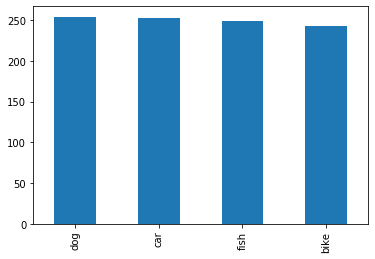

In [354]:
df = pd.DataFrame(output, columns=["Score", "Category"])
df.Category.value_counts().plot(kind='bar');

I hope that this solution was satisfactory. 

Best regards,
Arvid Gramer